<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Stories-EDA" data-toc-modified-id="Stories-EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Stories EDA</a></span><ul class="toc-item"><li><span><a href="#Score-Distribution" data-toc-modified-id="Score-Distribution-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Score Distribution</a></span></li><li><span><a href="#Comment-Count-Distribution" data-toc-modified-id="Comment-Count-Distribution-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comment Count Distribution</a></span></li><li><span><a href="#Post-Time-Distribution" data-toc-modified-id="Post-Time-Distribution-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Post Time Distribution</a></span></li><li><span><a href="#Users" data-toc-modified-id="Users-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Users</a></span><ul class="toc-item"><li><span><a href="#Mean-Score" data-toc-modified-id="Mean-Score-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Mean Score</a></span></li></ul></li><li><span><a href="#Controversational-Users" data-toc-modified-id="Controversational-Users-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Controversational Users</a></span></li><li><span><a href="#Titles'-Keywords" data-toc-modified-id="Titles'-Keywords-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Titles' Keywords</a></span><ul class="toc-item"><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Pre-processing</a></span></li><li><span><a href="#Calculating-TF-IDF" data-toc-modified-id="Calculating-TF-IDF-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Calculating TF-IDF</a></span></li></ul></li></ul></li><li><span><a href="#Comments-EDA" data-toc-modified-id="Comments-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Comments EDA</a></span></li></ul></div>

In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import itertools
from nltk.corpus import stopwords
import re
from tqdm import tqdm_notebook as tqdm

sns.set_palette(sns.color_palette("RdBu_r", 6))

In [2]:
load_path = 'hn_json'

with open(f'{load_path}.json', 'r') as f:
    hn_data = json.load(f)
    
hn_stories = {k : v for (k,v) in hn_data.items() if v['type'] == 'story'}
hn_comments = {k : v for (k,v) in hn_data.items() if v['type'] == 'comment'}

print(f'Imported {len(hn_stories.keys())} stories and {len(hn_comments.keys())} comments.')

Imported 21992 stories and 67977 comments.


In [3]:
print(hn_stories[list(hn_stories.keys())[3]], '\n')
print(hn_comments[list(hn_comments.keys())[1]])

{'by': 'onebeerdave', 'descendants': 0, 'id': 4, 'kids': [454413], 'score': 5, 'time': 1160419662, 'title': 'NYC Developer Dilemma', 'type': 'story', 'url': 'http://avc.blogs.com/a_vc/2006/10/the_nyc_develop.html'} 

{'by': 'pg', 'id': 17, 'kids': [1079], 'parent': 15, 'text': 'Is there anywhere to eat on Sandhill Road?', 'time': 1160423565, 'type': 'comment'}


### Stories EDA

#### Score Distribution

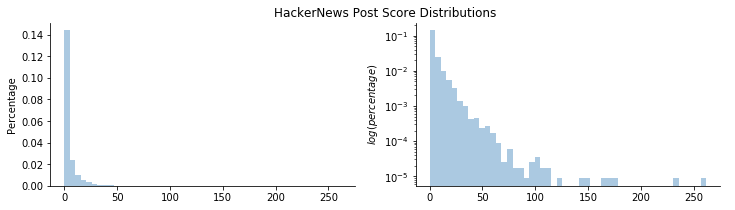

In [4]:
story_scores = [i.get('score', 0) for i in hn_stories.values()]

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)    # The big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax.set_title('HackerNews Post Score Distributions')

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.despine()

sns.distplot(story_scores, kde=False, norm_hist=True, ax=ax2)
sns.distplot(story_scores, kde=False, norm_hist=True, ax=ax1)
ax2.set_yscale('log')
ax2.set_ylabel('$log(percentage)$')
ax1.set_ylabel('Percentage')
plt.show()

#### Comment Count Distribution

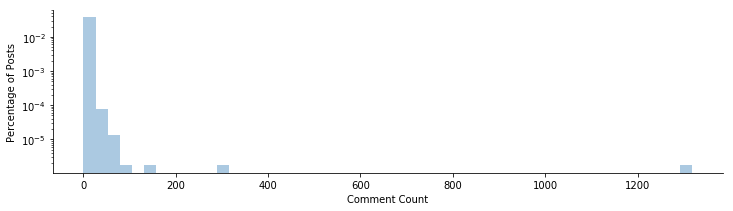

In [5]:
story_comment_counts = [len(i.get('kids', [])) for i in hn_stories.values()]
fig = plt.figure(figsize=(12,3))
sns.distplot(story_comment_counts, kde=False, norm_hist=True)
sns.despine()
plt.xlabel('Comment Count')
plt.ylabel('Percentage of Posts')
plt.yscale('log')
plt.show()

We can print details about highly controversial posts below. 

In [6]:
score_threshold = 120
over_score_list = [(i.get('id', ''), i.get('title', ''), (len(i.get('kids', [])))) for i in hn_stories.values() if len(i.get('kids', [])) > score_threshold]
over_score_list = [(f'https://news.ycombinator.com/item?id={i[0]}', i[1], i[2]) for i in over_score_list]
if len(over_score_list) == 1:
    res = 'result was:'
else:
    res = f'{len(over_score_list)} results were:'
print(f'The top {res}')
for i in over_score_list:
    print(str(i[1]) + ' ( ' + str(i[0]) + ' ) \n'+ str(i[2]) + ' comments\n')

The top 3 results were:
Please tell us what features you"d like in news.ycombinator ( https://news.ycombinator.com/item?id=363 ) 
1318 comments

Microsoft is Dead ( https://news.ycombinator.com/item?id=9770 ) 
297 comments

How old are you and what is your education level? ( https://news.ycombinator.com/item?id=63294 ) 
136 comments



#### Post Time Distribution

Grouping posts by year-month and counting the groups up gives us an idea of when posts were made. 

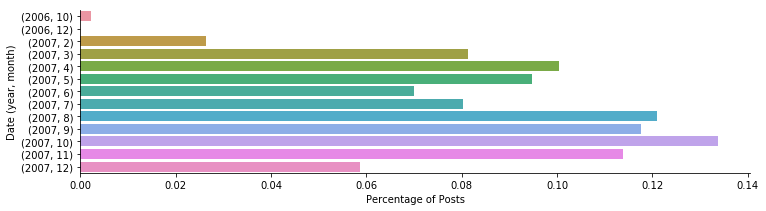

In [7]:
story_times = [datetime.fromtimestamp(i.get('time', 0)) for i in hn_stories.values() if i.get('time', 0) != 0]
story_times = [(i.year, i.month) for i in story_times]
story_times_counts = [len(list(group)) / len(story_times) for key, group in itertools.groupby(story_times)]
story_times_keys = [str(key) for key, group in itertools.groupby(story_times)]
fig = plt.figure(figsize=(12,3))
sns.barplot(story_times_counts, story_times_keys)
sns.despine()
plt.xlabel('Percentage of Posts')
plt.ylabel('Date (year, month)')
plt.show()

#### Users

##### Mean Score

First I'll create a dictionary of average scores for all users then extract the top average scorers from that.

In [8]:
story_user_scores = [(i.get('by', ''), i.get('score', 0)) for i in hn_stories.values()]
mean_user_score_dict = {}
for user_score in story_user_scores:
    user = user_score[0]
    score = user_score[1]
    
    if mean_user_score_dict.get(user, 0) == 0:
        mean_user_score_dict[user] = [score]
    else:
        mean_user_score_dict[user].append(score)
for user in mean_user_score_dict.keys():
    mean_user_score_dict[user] = sum(mean_user_score_dict[user]) / len(mean_user_score_dict[user])

mean_user_score_list = list(mean_user_score_dict.values())
top_user_list = sorted(mean_user_score_dict, key=mean_user_score_dict.get, reverse=True)[:75]
top_score_list = [mean_user_score_dict[i] for i in top_user_list]

Plotting the average scores and top scores for the Hackernews General Public.

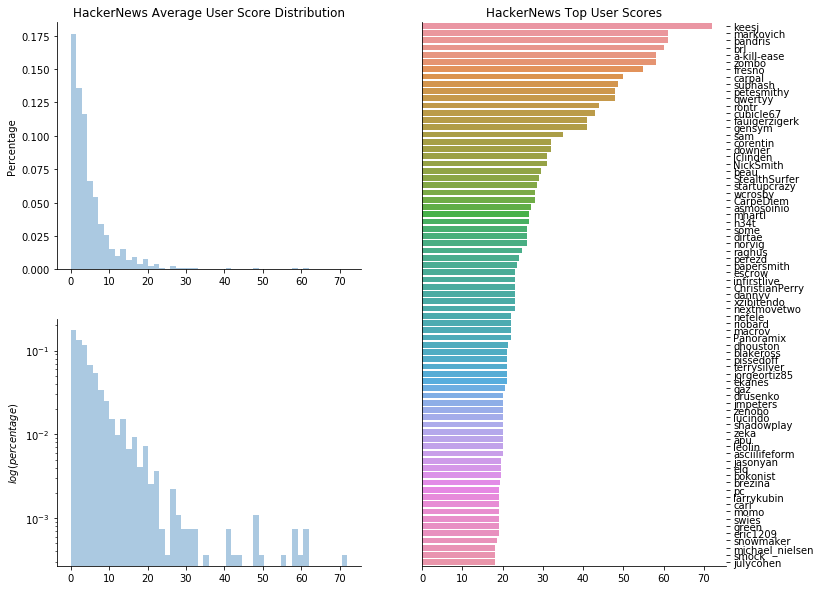

In [9]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)    # The big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)



grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.2)


ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[1,0])
ax3 = fig.add_subplot(grid[:,1])
sns.despine()

ax1.set_title('HackerNews Average User Score Distribution')
ax3.set_title('HackerNews Top User Scores')

sns.distplot(mean_user_score_list, kde=False, norm_hist=True, ax=ax2)
sns.distplot(mean_user_score_list, kde=False, norm_hist=True, ax=ax1)
sns.barplot(top_score_list, top_user_list, ax=ax3)
ax3.yaxis.tick_right()

ax2.set_yscale('log')
ax2.set_ylabel('$log(percentage)$')
ax1.set_ylabel('Percentage')
plt.show()

#### Controversational Users

Users creating posts which generate, on average, the largest number of comments.

In [10]:
story_user_ncomments = [(i.get('by', ''), len(i.get('kids', []))) for i in hn_stories.values()]
mean_user_ncomments_dict = {}
for user_ncomments in story_user_ncomments:
    user = user_ncomments[0]
    ncomments = user_ncomments[1]
    
    if mean_user_ncomments_dict.get(user, 0) == 0:
        mean_user_ncomments_dict[user] = [ncomments]
    else:
        mean_user_ncomments_dict[user].append(ncomments)
for user in mean_user_ncomments_dict.keys():
    mean_user_ncomments_dict[user] = sum(mean_user_ncomments_dict[user]) / len(mean_user_ncomments_dict[user])

mean_user_ncomments_list = list(mean_user_ncomments_dict.values())
top_user_list_ncomments = sorted(mean_user_ncomments_dict, key=mean_user_ncomments_dict.get, reverse=True)[:75]
top_ncomments_list = [mean_user_ncomments_dict[i] for i in top_user_list_ncomments]

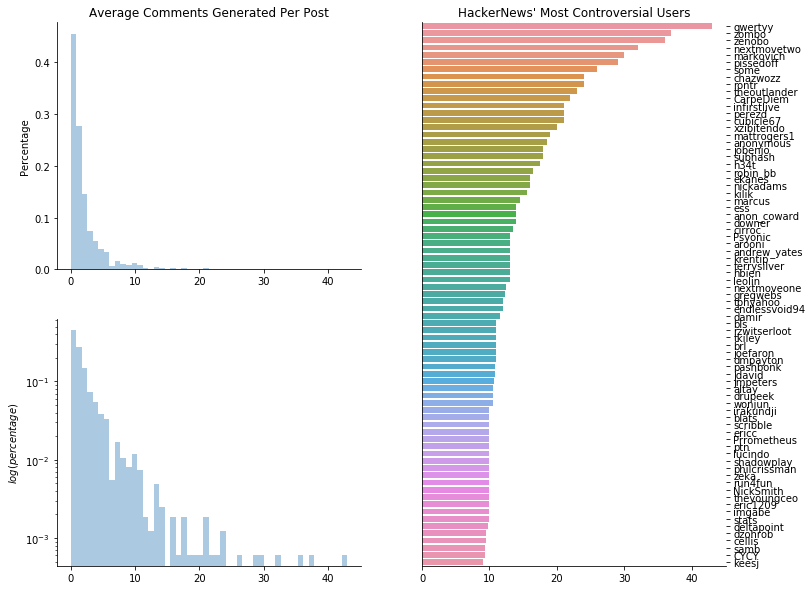

In [11]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)    # The big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)



grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.2)


ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[1,0])
ax3 = fig.add_subplot(grid[:,1])
sns.despine()

ax1.set_title('Average Comments Generated Per Post')
ax3.set_title('HackerNews\' Most Controversial Users')

sns.distplot(mean_user_ncomments_list, kde=False, norm_hist=True, ax=ax2)
sns.distplot(mean_user_ncomments_list, kde=False, norm_hist=True, ax=ax1)
sns.barplot(top_ncomments_list, top_user_list_ncomments, ax=ax3)
ax3.yaxis.tick_right()

ax2.set_yscale('log')
ax2.set_ylabel('$log(percentage)$')
ax1.set_ylabel('Percentage')
plt.show()

#### Titles' Keywords

First we'll replace unnecessary characters and remove stop words from the titles.

##### Pre-processing

In [27]:
story_titles = [i.get('title', '') for i in hn_stories.values()]
threshold = 50
story_score_threshold = [1 if i.get('score', 0) > threshold else 0 for i in hn_stories.values()]
story_titles = [re.sub('[\",:]', '', i).lower() for i in story_titles]
corpus = []
story_titles_str = ['' for i in range(0,len(story_titles))]
story_titles_list = []
for index, title in tqdm(enumerate(story_titles), total=len(story_titles)):
    filtered_title_list = [i for i in title.split(' ') if i not in stopwords.words('english')]
    story_titles_list.append(filtered_title_list)
    story_titles_str[index] = ' '.join(filtered_title_list)
    corpus += title.split(' ')
corpus = set(corpus)

print(story_titles_str[:50])


['combinator', 'students guide startups', 'woz interview early days apple', 'nyc developer dilemma', 'google youtube acquisition announcement could come tonight', 'business intelligence inkling way cool prediction markets software', 'sevin rosen unfunds - why?', 'likebetter featured bbc', 'weekendr social network weekend', 'photoshow broadcast photos cable tv', 'participation inequality encouraging users contribute', 'wired desktop dead', 'hardest lessons startups learn', 'small beautiful building successful company less capital', 'feld question regarding ndas', 'voddler raises $2.2m virtual cable tv', 'silicon light illuminate future?', 'salaries vc-backed companies', 'best irr ever?  youtube 1.65b...', 'myspace purely viral start', 'story going ipo bubble', 'spam stock tips work - spammers', 'google acquires youtube $1.6b', 'google!', 'get #1 news.yc', 'scratchtop - notepad web', 'woah scrybe! - new kind online organiser.', 'dot-com boom echoed deal buy youtube - new york times', 'c

##### Calculating TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

tfidf_arr = vectorizer.fit_transform(story_titles)

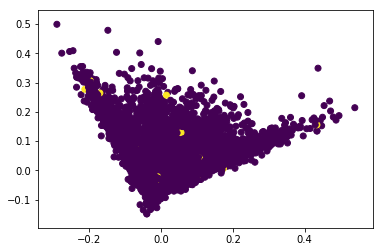

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(tfidf_arr.todense())
data2D = pca.transform(tfidf_arr.todense())
plt.scatter(data2D[:,0], data2D[:,1], c=story_score_threshold)
plt.show()        

### Comments EDA

First we need to make a dictionary containing all the stories and their associated comments.

In [ ]:
hn_stories_comments = hn_stories.copy()

for key, value in hn_stories.items():
    try:
        comment_ids = value['kids']
    except:
        continue
    comment_strings = ''
    for comment_id in comment_ids:
        comment_string = hn_comments.get(str(comment_id), ' ;')
        if isinstance(comment_string, dict):
            try: ### Need try here because deleted comments still return a dictionary with no `text`
                comment_string = comment_string['text']
            except:
                comment_string = '; '
        comment_strings += comment_string
        
    hn_stories_comments[key].update({'concat_comments' : comment_strings})

In [ ]:
hn_stories_comments

In [ ]:
hn_comments['15']